## Yubotu teža verzija

![title](yubotu2.png)

In [1]:
import z3
from z3 import Implies, Not, And, Bool, PbEq, sat

In [2]:
import matplotlib.pyplot as plt

def plot_model(m):
    mat = [[(i-j)%2 for i in range(10)] for j in range(10)]
    for i in range(10):
        for j in range(10):
            if m.evaluate(p[i][j]):
                mat[i][j] = 10 + (i-j) % 2
    plt.matshow(mat)

In [3]:
s = z3.Solver()
p = [[Bool("p{},{}".format(i, j)) for j in range(10)] for i in range(10)]
o = [[Bool("o{},{}".format(i, j)) for j in range(10)] for i in range(10)]
v = [[[Bool("v{},{},{}".format(i, j, k)) for k in range(2, 5)] for j in range(10)] for i in range(10)]
h = [[[Bool("h{},{},{}".format(i, j, k)) for k in range(2, 5)] for j in range(10)] for i in range(10)]


rows = [3, 1, 5, 1, 3, 1, 2, 3, 0, 1]
col = [2, 1, 1, 5, 3, 3, 0, 0, 3, 2]

In [4]:
# Broj popunjenih polja u redovima.
for (i, r) in enumerate(rows):
    s.add(z3.PbEq([(p[i][j],1) for j in range(10)], r))   

# Broj popunjenih polja u kolonama.
for (j, c) in enumerate(col):
    s.add(z3.PbEq([(p[i][j],1) for i in range(10)], c))

In [5]:
# Dijagonalni uslov. 
for i in range(10):
    for j in range(10):
        if (i < 9 and j < 9):
            s.add(Implies(p[i][j], Not(p[i+1][j+1])))
        if (i < 9 and j > 0):
            s.add(Implies(p[i][j], Not(p[i+1][j-1])))        
        if (i > 0 and j < 9):
            s.add(Implies(p[i][j], Not(p[i-1][j+1])))
        if (i > 0 and j > 0):
            s.add(Implies(p[i][j], Not(p[i-1][j-1])))

In [6]:
# Definisanje najmanjih podmornica.
for m in range(10):
    for n in range(10):
        vec = [p[m][n]]
        for i in range(m-1, m+1+1):
            for j in range(n-1, n+1+1):
                if (0 <= i <= 9) and (0 <= j <= 9) and ((i, j) != (m, n)):
                    vec += [Not(p[i][j])]
                    
        s.assert_and_track(Implies(o[m][n], And(vec)), str(o[m][n]) + " -> ")
        s.assert_and_track(Implies(And(vec), o[m][n]), "-> " + str(o[m][n]))

In [7]:
# Definisanje horizontalnih podmornica.
for m in range(10):
    for n in range(10):
        for k in range(2, 5):
            
            # Uslov da ne udaraju u zid.
            if n + k > 10:
                s.add(Not(h[m][n][k-2])) 
                continue
                      
            vec = []
            
            if 0 <= n-1 <= 9:
                vec += [Not(p[m][n-1])]
            if 0 <= n+k <= 9:
                vec += [Not(p[m][n+k])]
                
            vec += [p[m][j] for j in range(n, n+k)]
            
            if 0 <= m-1 <= 9:
                vec += [Not(p[m-1][j]) for j in range(n-1, n+k+1) if 0 <= j <= 9]
            if 0 <= m+1 <= 9:
                vec += [Not(p[m+1][j]) for j in range(n-1, n+k+1) if 0 <= j <= 9]
                
            s.assert_and_track(Implies(h[m][n][k-2], And(vec)), str(h[m][n][k-2]) + '->')
            s.assert_and_track(Implies(And(vec), h[m][n][k-2]), '->' + str(h[m][n][k-2]))

In [8]:
# Definisanje vertikalnih podmornica.
for m in range(10):
    for n in range(10):
        for k in range(2, 5):
            
            # Uslov da ne udaraju u zid.
            if m + k > 10:
                s.add(Not(v[m][n][k-2]))
                continue
            
            vec = []
            
            if 0 <= m-1 <= 9:
                vec += [Not(p[m-1][n])]
            if 0 <= m+k <= 9:
                vec += [Not(p[m+k][n])]
            
            vec += [p[i][n] for i in range(m, m+k)]
            
            if 0 <= n-1 <= 9:
                vec += [Not(p[i][n-1]) for i in range(m-1, m+k+1) if 0 <= i <= 9]
            if 0 <= n+1 <= 9:
                vec += [Not(p[i][n+1]) for i in range(m-1, m+k+1) if 0 <= i <= 9]
                
            s.assert_and_track(Implies(v[m][n][k-2], And(vec)), str(v[m][n][k-2]) + '->')
            s.assert_and_track(Implies(And(vec), v[m][n][k-2]), '->' + str(v[m][n][k-2]))

In [9]:
# Broj odgovarajucih podmornica.
for k in range(2, 5):
    vec = []
    for i in range(10):
        for j in range(10):
            vec += [(h[i][j][k-2], 1)]
            vec += [(v[i][j][k-2], 1)]
    s.assert_and_track(PbEq(vec, 5-k), 'k='+str(k))
    
vec = []
for i in range(10):
    vec += [(o[i][j], 1) for j in range(10)]
s.assert_and_track(PbEq(vec, 4), 'k=1')
        

In [10]:
# Pocetni uslovi igre.
s.add(h[6][0][2-2])
s.add(h[0][8][2-2])
s.add(Not(p[2][0]))
s.add(Not(p[5][8]))

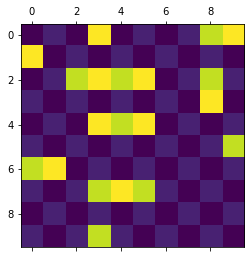

In [12]:
s.set(unsat_core=True)
if s.check() == sat:
    m = s.model()
    plot_model(m)
else:
    print(s.unsat_core())